# Neuronetwork analysis: graphs

Этот ноутбук посвящен введению в анализ сетевых структур: графовыми методами. Основные задачи: обзор существующих библиотек на python и базовых методов анализа сетевых данных.

### Онучин Арсений 
Факультет Психологии МГУ 

Моя почта: arseniyonuchin04.09.97@gmail.com

## Сетевые структуры

Сети при желании можно найти где угодно: любая форма взаимоотношений между объектами может быть представлена в виде сетевой структуры. В каких случаях это действительно осмысленно? Тогда, когда нас интересует "структура", образованная объектами и связями между ними в какой-то конкретной ситуации. Если бы нас интересовали свойства конкретной связи или конкретного объекта, то такого типа модель не была бы сильно осмысленной. Именно поэтому сетевые методы часто применяются для анализа общей структуры таких систем, как системы социальные, биологические, придумайте своё. Почему? Так ведь связи между ними, да и сами составляющие таких систем крайне вариативны. Это вам не звезды на небе, которые, конечно, тоже обладают некоторой интересной геометрией, но геометрией эволюционирующей очень медленно и неохотно, чего не скажешь о структуре социальных сообществ или группах нейронов. 

### Общая терминология 

В случае с графами используется достаточно просто математический формализм: есть множество вершин V и множество рёбер между вершинами E. По факту, каждое ребро -- просто пара вершин, поэтому всю запись можно свести к описанию в терминах вершин и их пар. 

Поэтому в контексте графового анализа мы будем понимать под сетью некоторый граф, который определяется как пара двух множеств: вершин и ребер между ними G := (V, E). Это самый простой из формальных объектов, в нем отсутствует даже информация о направлении связей! Давайте быстренько построим такой граф посредством библиотеки [NetworkX](https://networkx.org/). 


In [1]:
#!pip install networkx
#Уберите символ # со строчки выше, если библиотека networkx у вас не установлена и вызовите данную ячейку в блокноте

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import community # часть библиотеки networkx для выделения сообществ

G=nx.Graph() # пустой граф (как и с большинством математических структур, есть пример пустой структуры -- граф без вершин)
G.add_node(1) 
G.add_nodes_from([2,3,4,5,6,7])

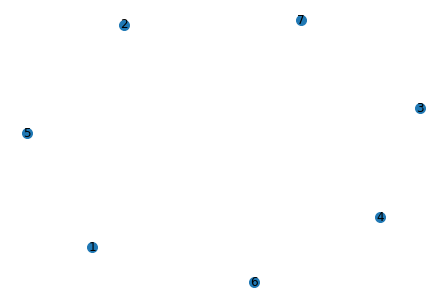

In [3]:
nx.draw(G,node_size=100,with_labels=True) 
#Это мы добавили вершины в граф, пока что там нет рёбер и он выглядит как-то так: 

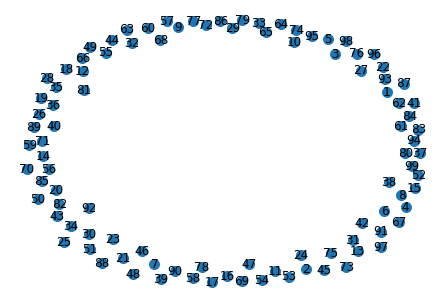

In [4]:
#функция arange удобна для создания массива чисел итеративным методом 
#первый параметр -- начало, второй -- конец, третий -- шаг
#то есть, вершины в граф можно добавлять сразу из списка 

nodes_list = np.arange(7,100,1)
G.add_nodes_from(nodes_list)
nx.draw(G,node_size=100,with_labels=True)

В функции отрисовки есть много разных параметров, которые можно указать. Здесь использован только основной аргумент функции -- сам граф G и два параметра: размер вершин на рисунке и наличие на них лейблов.

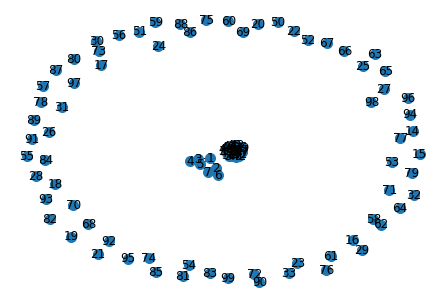

In [5]:
#Добавим рёбра в граф (пары вершин) и нарисуем то, что получилось

G.add_edge(1,2)
G.add_edges_from([(1,2),(1,3),(1,5),(4,5),(3,4),(3,5),(6,7),(7,5),(7,2),(6,2)])
edges_list1 = np.arange(8,14,1)
edges_list2 = np.arange(34,50,1)
edges_list = [[a,b] for a in edges_list1 for b in edges_list2 if a != b]

G.add_edges_from(edges_list)
#И нарисуем его снова

nx.draw(G,node_size=100,with_labels=True) 

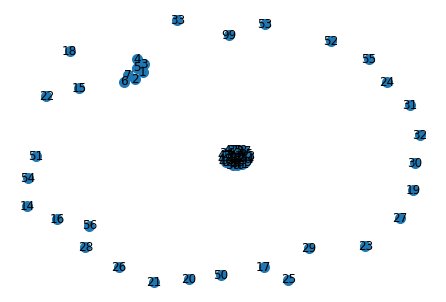

In [6]:
nodes_for_removing = nodes_list[50:-1]
G.remove_nodes_from(nodes_for_removing)
nx.draw(G,node_size=100,with_labels=True) 

Если весов на ребрах нет, а фиксировать какое-то расположение графа на плоскости хочется, то можно рассчитать координаты вершин с помощью встроенных функций layout. 

Возьмем spring_layout, в этом методе для вычисления координат вершин в пространстве в них помещаются заряды, а ребра заменяют на "пружинки". Равновесное состояние такое системы зарядов определяет координатное представление сети. 

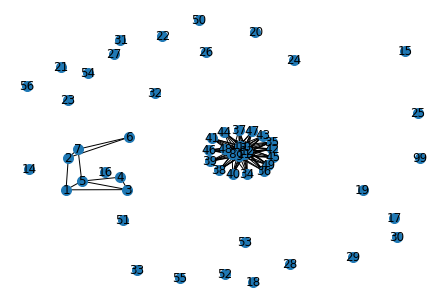

In [7]:
spring=nx.spring_layout(G,iterations=10)
nx.draw(G,spring,node_size=100,with_labels=True)

Можно нарисовать граф по иному шаблону, расположив вершины по окружности. 

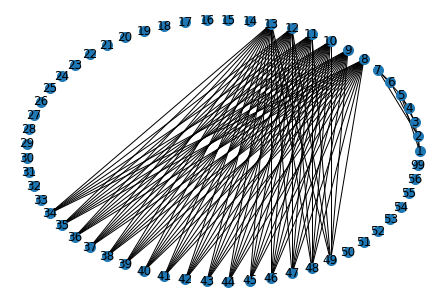

In [8]:
circle_G = nx.drawing.layout.circular_layout(G)
nx.draw(G,circle_G,node_size=100,with_labels=True)

Или, наоборот, рандомизировать расположение вершин, если они слипаются в один класс. Другие варианты можно посмотреть в документации библиотеки по [ссылке](https://networkx.org/documentation/stable/reference/drawing.html). 

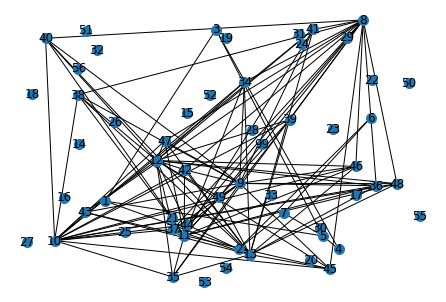

In [9]:
random_G = nx.drawing.layout.random_layout(G)
nx.draw(G,random_G,node_size=100,with_labels=True)

Если бы у нас были некоторые "веса" на рёбрах, например, расстояния между вершинами-городами, то структура бы имела однозначную метрическую реализацию (с точностью до изометрии). Пока забудем про это, но вернемся чуть позже. 

Наиболее удобной формой представления графа является матрица смежности (adjacency matrix). Это двумерный квадратный массив, где строки и столбцы -- вершины, а в ячейках на пересечениях стоят 0 или 1, которые говорят о наличии или отсутствии ребра между соответствующими вершинами. 


Если граф ненаправленный, то матрица получится симметричной (относительно диагонали, так как ребро есть как в одну, так и в другую сторону), если граф направленный, то и матрица будет несимметричной. Если есть петли (связь вершины с самойсобой), то по диагонали матрицы тоже могут находиться значения. Иногда в ячейках не 1/0, а вес связи, например, число дорог между двумя городами. 

По уже построенному графу, через список его ребер и вершин, можно восстановить матрицу смежности. 

In [10]:
A=nx.adjacency_matrix(G).todense()
print(A)

[[0 1 1 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Как мы видим, петель нет (нули на диагонали), граф невзвешенный (никаких значений кроме 1/0 нет), граф ненаправленный (матрица симметричная). 

Можно нарисовать матрицу картинкой!

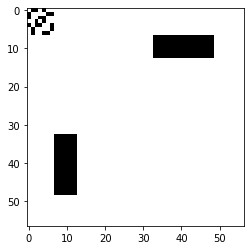

In [11]:
plt.imshow(A,cmap='binary')

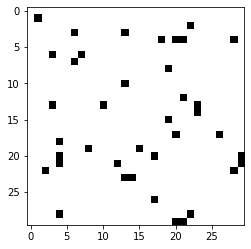

In [12]:
# Можно ребра сгенерировать рандомно и посмотреть на матрицу смежности случайного графа
random_edges = np.random.randint(30,size=(20,2))
nodes_new = np.arange(0,30,1)
G_rand = nx.Graph()
G_rand.add_nodes_from(nodes_new)
G_rand.add_edges_from(random_edges)

B = nx.adjacency_matrix(G_rand).todense()
plt.imshow(B,cmap='binary')

### Направленные графы

Вполне актуальная задача в нейронауках -- построение направленных графовых структур. Такой объект в библиотеке NetworkX задается через DiGraph().

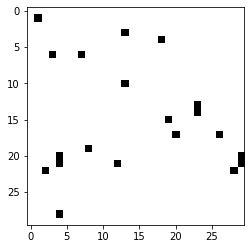

In [13]:
Di_G = nx.DiGraph()
Di_G.add_nodes_from(nodes_new)
Di_G.add_edges_from(random_edges)
Di_M = nx.adjacency_matrix(Di_G).todense()
plt.imshow(Di_M, cmap='binary')

Как мы видим, матрица несимметрична относительно диагонала, а значит, граф направленный. 

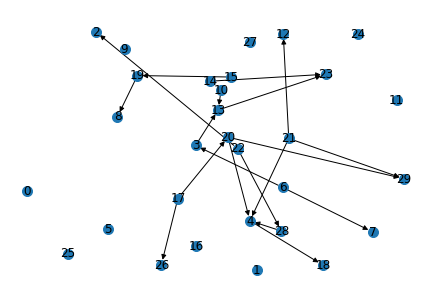

In [14]:
spring=nx.spring_layout(Di_G,iterations=10)

nx.draw(Di_G,spring,node_size=100,with_labels=True)

## Графовое представление датасета


Теперь, когда мы научились создавать графовые объекты и все такое, можно попробовать сделать это из реальных данных. 

Загрузим модельные данные [отсюда](https://programminghistorian.org/assets/exploring-and-analyzing-network-data-with-python/quakers_nodelist.csv) и [отсюда](https://programminghistorian.org/assets/exploring-and-analyzing-network-data-with-python/quakers_edgelist.csv). В первом файле хранятся вершины графа, во втором его рёбра. Это пример социального графа, где в первом файле всякие данные по людям, а во втором пары имен, говорящие о наличии социального контакта между ними. Ниже приведены несколько первых строчек файла вершин. 

Мы будем считать, что если один человек знает другого, то это верно и в обратную сторону. То есть, наш граф будет ненаправленным. Пример первых строк второго файла с рёбрами графа ниже. 

Откроем файлы посредством библиотеки csv. Можно было бы использовать и pandas, там тоже есть модуль для открытия csv файлов. 

In [15]:
import csv
from operator import itemgetter

В ' ' необходимо указать путь до файла на своём компьютере. После того, как вы скачали файл, он находится в конкретной директории и к нему есть определенный путь, по которому его можно найти! Обратите внимание, что при копировании пути до файла из его описания вместо символов / встречаются \, а для корректной работы функции нужны /. 

In [16]:
with open('D:/Библиотека/Data/data/Для ноутбука на конкурс/quakers_nodelist.csv', 'r') as nodecsv: # Открытие файла
    nodereader = csv.reader(nodecsv) # Чтение файла csv
    # Преобразует данные в питоновский список, начиная с первой строки (нулевая строка с заголовком исключается)
    nodes = [n for n in nodereader][1:]

node_names = [n[0] for n in nodes] # Выделение списка, состоящего только из имен вершин -- нулевой столбец

with open('D:/Библиотека/Data/data/Для ноутбука на конкурс/quakers_edgelist.csv', 'r') as edgecsv: # Открытие второго файла
    edgereader = csv.reader(edgecsv) # Его чтение
    edges = [tuple(e) for e in edgereader][1:] # Преобразование данных в tuple

Посмотреть число вершин и ребер можно и до построения графа по данным методами библиотеки NetworkX. 

In [17]:
print(len(node_names))
print(len(edges))

119
174


Создадим граф на загруженных данных:

In [18]:
Social_network = nx.Graph()

Social_network.add_nodes_from(node_names)
Social_network.add_edges_from(edges)

Базовую информацию по графу можно получить через вызов функции info. Averafe degree -- средняя степень вершины, то есть, среднее число ребер, которое выходит из каждой вершины (или среднее число знакомых на каждого человека в нашей социальной сети).

In [19]:
print(nx.info(Social_network))

Name: 
Type: Graph
Number of nodes: 119
Number of edges: 174
Average degree:   2.9244


В файле содержалось много дополнительной информации: пол, дата рождения и смерти, номер полиса. Можно сохранить данную информацию в графе, прикрепив словарики к вершинам. Словарь -- это такой формат данных, где хранятся пары (ключ, некоторое множество объектов). То есть, по каждому ключу, в данном случае -- по имени участника, вызывается некоторый набор объектов из словаря. Объектами будут выступать данные из других колонок: Historical Significance, Gender, Birthdate, Deathdate, ID. 

In [20]:
hist_sig_dict = {}
gender_dict = {}
birth_dict = {}
death_dict = {}
id_dict = {}

for node in nodes: # Цикл по списку вершину
    hist_sig_dict[node[0]] = node[1]
    gender_dict[node[0]] = node[2]
    birth_dict[node[0]] = node[3]
    death_dict[node[0]] = node[4]
    id_dict[node[0]] = node[5]

Теперь, когда у нас есть множество словарей, мы можем добавить их к графовому объекту, так, чтобы к каждой вершине был привязан соответствующий набор ключей их словарей. Это можно сделать посредством функции set_node_attributes() из NetworkX, которая принимает на вход три аргумента: имя графа, к вершинам которого приклеиваются атрибуты, словарь с атрибутами и их ключами и имя, которое будет присвоено новому атрибуту. 

In [21]:
nx.set_node_attributes(Social_network, hist_sig_dict, 'historical_significance')
nx.set_node_attributes(Social_network, gender_dict, 'gender')
nx.set_node_attributes(Social_network, birth_dict, 'birth_year')
nx.set_node_attributes(Social_network, death_dict, 'death_year')
nx.set_node_attributes(Social_network, id_dict, 'sdfb_id')

Все вершины графа имеют по 6 атрибутов и их можно вызвать в любое время.

In [22]:
for n in Social_network.nodes(): # Цикл по вершинам графа
    print(n, Social_network.nodes[n]['birth_year']) # Выделяет каждую вершину по её индексу и дальше получает доступ к атрибуту

Joseph Wyeth 1663
Alexander Skene of Newtyle 1621
James Logan 1674
Dorcas Erbery 1656
Lilias Skene 1626
William Mucklow 1630
Thomas Salthouse 1630
William Dewsbury 1621
John Audland 1630
Richard Claridge 1649
William Bradford 1663
Fettiplace Bellers 1687
John Bellers 1654
Isabel Yeamans 1637
George Fox the younger 1551
George Fox 1624
John Stubbs 1618
Anne Camm 1627
John Camm 1605
Thomas Camm 1640
Katharine Evans 1618
Lydia Lancaster 1683
Samuel Clarridge 1631
Thomas Lower 1633
Gervase Benson 1569
Stephen Crisp 1628
James Claypoole 1634
Thomas Holme 1626
John Freame 1665
John Swinton 1620
William Mead 1627
Henry Pickworth 1673
John Crook 1616
Gilbert Latey 1626
Ellis Hookes 1635
Joseph Besse 1683
James Nayler 1618
Elizabeth Hooten 1562
George Whitehead 1637
John Whitehead 1630
William Crouch 1628
Benjamin Furly 1636
Silvanus Bevan 1691
Robert Rich 1607
John Whiting 1656
Christopher Taylor 1614
Thomas Lawson 1630
Richard Farnworth 1630
William Coddington 1601
Thomas Taylor 1617
Richard 

## Графовые метрики

Когда вы начинаете работать с новым датасетом, важно получить общее представление о его структуре. Первым шагом является просто открытие файла с данными и осмотр того, что попало внутрь и последующее построение графа. Затем, считаются базовые статистики по графу: число ребер, вершин, среднюю степень, но какие ещё характеристики можно выделить из каждого конкретного графа?

Для решения задачи сравнения полученных графовых структур вычисляются различные графовые статистики или метрики (как их иногда называют). Это некоторые признаки, которые количественно характеризуют тот или иной граф. Например, число компонент связности, наибольшая степень вершины, длина кратчайшего маршрута и так далее. Большая часть стандартных метрик такого типа уже есть в готовом виде в библиотеке NetworkX. 

Выбор метрик зависит от базовых особенностей графа. Например, направленность или ненаправленность графа определяет возможность применения для его анализа специфических метрик. Ах да, еще два важных понятия: локальные и глобальные метрики. Локальные -- свойства конкретной вершины, глобальные -- свойства всего графа (вроде просто). 

Первым шагом сделаем то, что мы уже умеем:

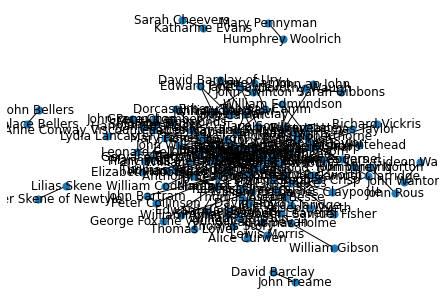

In [23]:
sspring=nx.spring_layout(Social_network,iterations=10)
nx.draw(Social_network,sspring,node_size=50,with_labels=True)

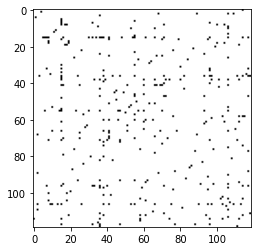

In [24]:
SN = nx.adjacency_matrix(Social_network).todense()
plt.imshow(SN,cmap='binary')

### Локальные метрики

Многие характеристики сети локальны, т.е. определяются для каждой вершины графа. Для таких характеристик исследуется поведение соответствующего распределения признаков (они представляются как значения некоторой случайной величины X). Рассмотрим такую локальную характеристику графа, как степень вершины -- число рёбер, в состав которых данная вершина входит. 

Построим распределение степеней вершин (degree distribution)

In [25]:
degrees = sorted([d for n, d in Social_network.degree()], reverse=True)
print(degrees)

[22, 18, 16, 13, 13, 10, 9, 8, 8, 7, 7, 6, 6, 6, 6, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Сразу бросается в глаза вершина с крайне большим значением степени (лидер?) и то, что большинство имеет всего одну социальную связь. Построим гистограмму частот степеней вершин графа. 

Text(0, 0.5, '$\\rho$')

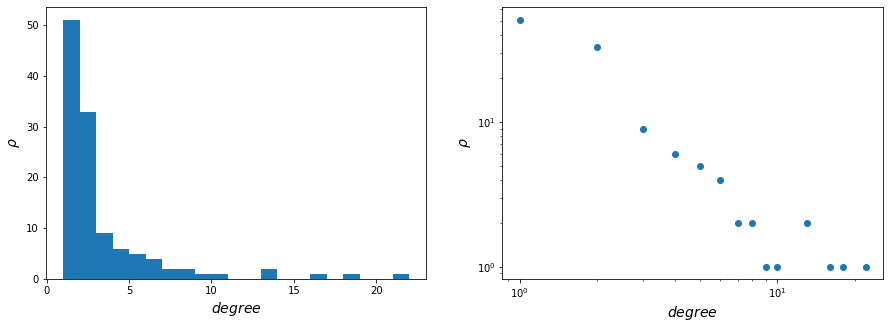

In [26]:
ro=np.bincount(degrees) # Число вершин с определенным значением степени 
x=np.nonzero(ro) # Исключаем нули из массива ro так как там учитвались все степени от 0 до 22 (до максимальной)
y=ro[np.nonzero(ro)] # Сохраняем сюда число ненулевых степеней

fig, ax = plt.subplots(nrows=1, sharey=False,ncols=2, figsize=(15, 5))

ax[0].hist(degrees, bins=max(degrees)-min(degrees))
ax[0].set_xlabel(r'$ degree$', fontsize=14)
ax[0].set_ylabel(r'$\rho$', fontsize=14)

ax[1].scatter(x,y)
ax[1].set_xscale('log') # Многие сети имеют интересное степенное распределение степеней вершин
ax[1].set_yscale('log') # Поэтому представим x,y в логарифмической шкале
ax[1].set_xlabel(r'$ degree$', fontsize=14)
ax[1].set_ylabel(r'$\rho$', fontsize=14)

Существует такой математический объект, как степенное распределение или распределение Парето и очень многие природные явления обладают параметрами, удовлетворяющими такому распределению. Можно заметить, что распределение степеней вершин обладает тяжелым хвостом и сильно напоминает распределение Парето. $$\rho(d)\approx d^{-\gamma},$$ Попробуем оценить параметр распределения $\gamma$:

In [27]:
xlog=np.log(np.reshape(x,len(y))) 
ylog=np.log(y)
coeff=np.polyfit(xlog,ylog,1) 
print(coeff)

[-1.42291275  3.86361671]


Показатель распределения $\gamma~\approx -1.4$, отметим, что для практически всех реальных сетей это показатель лежит в промежутке [-3,-2]! Такие сети называются безмасштабными сетями (scale-free network). 

### Глобальные метрики

Так как граф уже достаточно большой, визуально оценить его свойства сложно. 

Хорошая графовая метрика, с которой можно начать -- плотность сети (network density). По сути, это отношение числа рёбер в графе к максимальному возможному числу рёбер в графе (граф, в котором все вершины попарно соеденены, называется полным). Очевидно, что в неориентированном графе на n вершинах возможно n(n-1)/2 рёбер (число неупорядоченных пар из двух вершин). 

Вычисления параметра плотности сети осуществляется через вызов готовой функции nx.density(): просто подставь аргумент и получишь число. Максимально просто!

In [28]:
density = nx.density(Social_network)
print("Плотность сети:", density)

Плотность сети: 0.02478279447372169


Плотность сети это число в диапазоне от 0 до 1. У нас получилось примерно 0.024. О чем это говорит? Плотность низкая, контактов мало, больше ничего и не скажешь по одному этому коэффициенту. 

Следующая метрика, которую мы рассмотрим -- кратчайший путь (shortest path). Эта функция находит наименьший по длине путь (последовательность ребер и вершин) между какими-то двумя конкретными вершинами. Так можно найти, например, друзей своих друзей, с которыми они тесно общаются, но вы лично не знакомы. 

Библиотечная функция nx.shortest_path() требует на вход три аргумента: графовый объект, вершину начало пути и вершину конец пути. Чем больше граф и больше в нем ребер (выше плотность), тем дольше будет работать алгоритм. На выходе функция выдаст список имен вершин, из которых состоит путь. 

In [29]:
#Возьмем каких-то двух челов из нашего графа и найдем кратчайший путь между ними. 

fell_whitehead_path = nx.shortest_path(Social_network, source="Margaret Fell", target="George Whitehead")

print("Кратчайший путь между Fell и Whitehead:", fell_whitehead_path)

Кратчайший путь между Fell и Whitehead: ['Margaret Fell', 'George Fox', 'George Whitehead']


Такоё ещё нюанс: если между вершинами нет пути, то есть, они как бы лежат в двух отдельных компонентах графа, то функция поиска кратчайшего пути выдаст ошибку "NetworkXNoPath".

In [30]:
dorothy_whitehead_path = nx.shortest_path(Social_network, source="Dorothy Waugh", target="George Whitehead")

print("Кратчайший путь между Fell и Whitehead:", fell_whitehead_path)

NetworkXNoPath: No path between Dorothy Waugh and George Whitehead.

Готовых функций в библиотеке NetworkX для работы с путями очень много, можно глянуть список в [документации](https://networkx.org/documentation/stable/reference/algorithms/shortest_paths.html). 

Есть много разных метрик, получаемых из длин кратчайших путей. Одна из таких метрик -- диаметр графа. Диаметр -- наиболее длинный из всех кратчайших путей в графе. После подсчета всех кратчайших путей в графе (для каждой пары вершин), диаметром называется наибольшая длина пути между наиболее разобщенными вершинами, однако, между ними все-таки существует путь, это не вершины, лежащие в различных компонентах графа. 

Функция вычисления диаметра графа -- снова всего одно слово nx.diameter(), да и аргумент всего один -- имя графового объекта. Но вызов этой функции на нашем графе выдаст снова ошибку, сходную с той, которую мы видели выше Graph is “not connected.” 

Чтобы избежать лишних шагов и ошибок, следующих из вызова функций, которые зависят от связности графа, можно делать следующее:

In [31]:
# Если в графе более одной компоненты связности, то данная функция выведет False
print(nx.is_connected(Social_network))

# Далее, используйте nx.connected_components, чтобы получить список компонент связности графа
# и функцию max(), чтобы найти наибольшую компоненту:
components = nx.connected_components(Social_network)
largest_component = max(components, key=len)

False


Из вычисленной наибольшей компоненты в графе можно сделать тоже графовый объект, который будет подграфом, относительно изначального графа. Данный подграф будет связным, а значит, для него можно будет вычислить диаметр.

In [32]:
subgraph = Social_network.subgraph(largest_component)
diameter = nx.diameter(subgraph)
print("Диаметр наибольшей компоненты:", diameter)

Диаметр наибольшей компоненты: 8


И нарисуем его, раз уж на то пошло:

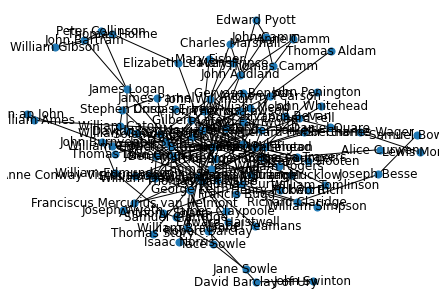

In [33]:
sspring=nx.spring_layout(subgraph,iterations=10)
nx.draw(subgraph,sspring,node_size=50,with_labels=True)

Так как мы взяли наибольшую компоненту, то можно предположить, что и диаметра больше в нашем графе не будет. В отличие от нормированного показателя плотности сети, в случае с диаметром может быть проблемно сказать наверняка -- большой он или маленький, так как этот показатель может очень сильно меняться в зависимости от графа. 

Давайте посчитаем теперь triadic closure. Что эта характеристика показывает? Основная гипотеза, для проверки которой высчитывался этот коэффициент -- если два человека (A,B) знают третьего (есть ребро из A в C и из B в C), то велика вероятность того, что A и B также знают и друг друга. Тогда сопоставим число всех таких троек в графе, где двое знают одного с числом "треугольников" (когда A,B,C знают друг друга попарно). Такие "треугольники" называются кликами или полными подграфами и они крайне важны для многих форм анализа данных. 

Вычисляется эта характеристика тоже в вызов одной пакетной функции, так что ничего особенного делать не придется. 

In [34]:
triadic_closure = nx.transitivity(Social_network)
print("Triadic closure:", triadic_closure)

Triadic closure: 0.16937799043062202


### Центральность

Показатель центральности определяет наиболее важные вершины графа. Например, показатель выявляет наиболее влиятельное лицо в социальной сети, ключевые узлы инфраструктуры и разносчиков болезни. По идее, сделать это можно разными способами, поэтому разберём несколько мер центральности: степень вершины (degree), степень посреднечества (betweenness centrality) и степень влиятельности (eigenvector centrality).

Начнем с самого простого -- степени вершины. Вершины с наибольшей степенью в графе порой называют хабами. Это вершины, которые имеют наибольшее число связей с другими вершинами в графе. 

Вычисление центральности для любой вершины посредством библиотеки NetworkX все также требует всего одной строчки (обычно). Все функции, вычисляющие меру центральности возвращают словарь с ключами-вершинами и со значениями мерами центральности. Что означает, что их можно будет сразу же добавить в графовый объект как атрибуты вершин (что мы уже делали). 

In [35]:
degree_dict = dict(Social_network.degree(Social_network.nodes()))
nx.set_node_attributes(Social_network, degree_dict, 'degree')

Поэтому теперь можно увидеть информацию по вершине 'William Penn', которая также будет включать в себя степень этой вершины.

In [36]:
print(Social_network.nodes['William Penn'])

{'historical_significance': 'Quaker leader and founder of Pennsylvania', 'gender': 'male', 'birth_year': '1644', 'death_year': '1718', 'sdfb_id': '10009531', 'degree': 18}


Можно также отсортировать методом sorted() для сортировки словаря по его ключам или значениям и найти верхие 20 вершин по степени.  

In [37]:
sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)

Многое происходит за сценой и свернуто внутрь вызванной нами функции sorted(), поэтому давайте остановимся на аргументах, которые она получает на вход. Первый аргумент -- словарь, который мы хотим отсортировать. Второй аргумент -- то, по чему мы хотим сортировать и в данной случае “1” означает по элементам словаря, а не по ключам. Третий аргумент про сортировку в обратном порядке, что выведет вершины с наибольшей степенью первыми в списке. 

In [38]:
print("Двадцать первых вершин по степени:")
for d in sorted_degree[:20]:
    print(d)

Двадцать первых вершин по степени:
('George Fox', 22)
('William Penn', 18)
('James Nayler', 16)
('George Whitehead', 13)
('Margaret Fell', 13)
('Benjamin Furly', 10)
('Edward Burrough', 9)
('George Keith', 8)
('Thomas Ellwood', 8)
('Francis Howgill', 7)
('John Perrot', 7)
('John Audland', 6)
('Richard Farnworth', 6)
('Alexander Parker', 6)
('John Story', 6)
('John Stubbs', 5)
('Thomas Curtis', 5)
('John Wilkinson', 5)
('William Caton', 5)
('Anthony Pearson', 5)


### Степень влиятельности (eigenvector centrality)

Хорошо, что есть меры центральности, который позволяют находить не только хабы. Степень влиятельности во многом похожа на вычисление степени вершины, но является как бы развитием этого понятия. Она строится на анализе степени вершины и степенях соседей данной вершины. То есть, эта мера центральности, которая не только учитывает, является ли вершина хабом, но также и то, с каким числом хабов данных хаб соединен. Степень влиятельности также изверяется значениями из промежутка $[0,1]$. Эта мера удобна для определения тех вершин, которые могут быстрее остальных распространять информацию по сети. Алгоритм PageRank от Google использует принцип, основанный на степени влиятельности: страницы выводятся в порядке наибольшего значения коэффициента, схожего с коэффициентом степени влиятельности, ведь сайты -- те же вершины графа в мировой паутине! 

В нейронауках было обнаружено, что степень влиятельности нейрона в модели нейронной сети коррелирует с относительной частотой возбуждения!  (doi:10.1142/S0129065717500137)


In [39]:
eigenvector_dict = nx.eigenvector_centrality(Social_network) 
nx.set_node_attributes(Social_network, eigenvector_dict, 'eigenvector')

In [40]:
sorted_betweenness = sorted(eigenvector_dict.items(), key=itemgetter(1), reverse=True)

print("Первые 20 вершин по степени влиятельности:")
for b in sorted_betweenness[:20]:
    print(b)

Первые 20 вершин по степени влиятельности:
('George Fox', 0.4491750710859924)
('James Nayler', 0.3352974100447867)
('William Penn', 0.2703220115399868)
('Margaret Fell', 0.253170949905681)
('George Whitehead', 0.2497455334914196)
('Edward Burrough', 0.23147427604862297)
('Francis Howgill', 0.1909539378268105)
('Benjamin Furly', 0.1878520634691651)
('John Perrot', 0.1849692807795611)
('George Keith', 0.18384690867915351)
('Thomas Ellwood', 0.17608142535843857)
('Richard Farnworth', 0.15368535029296415)
('John Crook', 0.1327158126880779)
('Rebecca Travers', 0.1184804064465093)
('Alexander Parker', 0.11587808682088324)
('Anthony Pearson', 0.11120476725256784)
('William Dewsbury', 0.11057869321157121)
('John Stubbs', 0.10693500692141825)
('John Audland', 0.0983088971933375)
('Thomas Salthouse', 0.09548628544138771)


### Степень посреднечества (betweenness centrality)

Степень посредничества немного отличается от двух предыдущих мер, потому что она не учитывает степени вершин. Степень посредничества учитывает все кратчайшие пути, проходящие через конкретную вершину. Для этого алгоритму необходимо вычислить все кратчайшие пути внутри графа, именно поэтому данная мера центральности достаточно ресурсоемкая в плане вычислений. Степень посредничества подходит для вычисления таких вершин, которые соединяют друг с другом два разделенных кластера/подграфа. В отличие от хаба, такой тип вершины обычно называют брокером. 

In [41]:
betweenness_dict = nx.betweenness_centrality(Social_network) 
nx.set_node_attributes(Social_network, betweenness_dict, 'betweenness')

In [42]:
sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)

print("Первые 20 вершин по степени посредничества:")
for b in sorted_betweenness[:20]:
    print(b)

Первые 20 вершин по степени посредничества:
('William Penn', 0.23999456006192205)
('George Fox', 0.23683257726065216)
('George Whitehead', 0.12632024847366005)
('Margaret Fell', 0.12106792237170329)
('James Nayler', 0.10446026280446098)
('Benjamin Furly', 0.06419626175167242)
('Thomas Ellwood', 0.046190623885104545)
('George Keith', 0.045006564009171565)
('John Audland', 0.04164936340077581)
('Alexander Parker', 0.03893676140525336)
('John Story', 0.028990098622866983)
('John Burnyeat', 0.028974117533439564)
('John Perrot', 0.02829566854990583)
('James Logan', 0.026944806605823553)
('Richard Claridge', 0.026944806605823553)
('Robert Barclay', 0.026944806605823553)
('Elizabeth Leavens', 0.026944806605823553)
('Thomas Curtis', 0.026729751729751724)
('John Stubbs', 0.024316593960227152)
('Mary Penington', 0.02420824624214454)


Можно заметить, что многие из вершин, находиящихся в топе по степеням, оказались также в топе и по степени посредничества. 
Давайте сопоставим словарь степеней вершин и словарь степеней посредничества вершин, надеясь отыскать те вершины, которые имеют высокий показатель степени посредничества, но при этом малую степень!

In [43]:
# Возьмем списком первые 20 вершин, отсортированных по степени посредничества
top_betweenness = sorted_betweenness[:20]

# Найдем и выведем их степени
for tb in top_betweenness: 
    degree = degree_dict[tb[0]] 
    print("Имя:", tb[0], "| Степень посредничества:", tb[1], "| Степень:", degree)

Имя: William Penn | Степень посредничества: 0.23999456006192205 | Степень: 18
Имя: George Fox | Степень посредничества: 0.23683257726065216 | Степень: 22
Имя: George Whitehead | Степень посредничества: 0.12632024847366005 | Степень: 13
Имя: Margaret Fell | Степень посредничества: 0.12106792237170329 | Степень: 13
Имя: James Nayler | Степень посредничества: 0.10446026280446098 | Степень: 16
Имя: Benjamin Furly | Степень посредничества: 0.06419626175167242 | Степень: 10
Имя: Thomas Ellwood | Степень посредничества: 0.046190623885104545 | Степень: 8
Имя: George Keith | Степень посредничества: 0.045006564009171565 | Степень: 8
Имя: John Audland | Степень посредничества: 0.04164936340077581 | Степень: 6
Имя: Alexander Parker | Степень посредничества: 0.03893676140525336 | Степень: 6
Имя: John Story | Степень посредничества: 0.028990098622866983 | Степень: 6
Имя: John Burnyeat | Степень посредничества: 0.028974117533439564 | Степень: 4
Имя: John Perrot | Степень посредничества: 0.02829566854

## Поиск сообществ в графе методом модулярности

Следующий самонапрашивающийся вопрос о структуре графа -- вопрос о сообществах внутри графа. Как их выделять? Сколько их и какую они имеют природу? Существует много способов выделения сообществ, клик и кластеров, но наиболее популярный -- модулярный. Модулярность -- мера относительной плотности сети. Сообщество (или модуль) имеет высокую плотность относительно вершин, которые относятся к данному сообществу и низкую плотность относительно всех остальных вершин графа. Модулярность даёт обобщенную оценку разобщенности сети и этот показатель можно использовать, чтобы выделять отдельные сообщества из сети. 

Плотные сети разделять на осмысленные части сложно. Удачно, что модельный граф, с которым мы работаем, не особо-то и плотный, как мы видели выше. 

Плотность сети: $0.02478279447372169$

К тому же, данная сеть несвязная, то есть, в ней существуют уже изолированные сообщества. Давайте попробуем применить пакетный метод подсчета модулярности и посмотрим на получившиеся сообщества.


In [44]:
communities = community.greedy_modularity_communities(Social_network)

Метод greedy_modularity_communities() считает число сообществ, принадлежащих графу и группирует все вершины по подграфам, совпадающим с выделенными сообществами. В отличие от мер центральности, данный метод не вернёт словарь, список специальных “frozenset” объектов (похожи на списки). Для того чтобы добавить эту информацию про сообщества в граф, необходимо создать словарь, который бы маркировал все вершины номерами их семейств: 

In [50]:
modularity_dict = {} # создадим пустой словарь
for i,c in enumerate(communities): # c -- сообщество
    for name in c: # цикл по людям внутри каждого сообщества
        modularity_dict[name] = i 

# Добавим информацию о модулярности к вершинам
nx.set_node_attributes(Social_network, modularity_dict, 'modularity')

Конечно, вы всегда можете скомбинировать выделенные методом модулярности сообщества с иными графовыми мерами, например, центральности. Например, давайте найдем наибольшие по степени влиятельности вершины в 0 классе: 

In [52]:
# список вершин в этом 0 классе
class0 = [n for n in Social_network.nodes() if Social_network.nodes[n]['modularity'] == 0]

# словарь для степеней влиятельности
class0_eigenvector = {n:Social_network.nodes[n]['eigenvector'] for n in class0}

# отсортируем этот словарь и выпишем первые 5 элементов
class0_sorted_by_eigenvector = sorted(class0_eigenvector.items(), key=itemgetter(1), reverse=True)

print("Модулярный класс 0 отсортированный по степеням влиятельности:")
for node in class0_sorted_by_eigenvector[:5]:
    print("Имя:", node[0], "| Степень влиятельности:", node[1])

Модулярный класс 0 отсортированный по степеням влиятельности:
Имя: William Penn | Степень влиятельности: 0.2703220115399868
Имя: George Keith | Степень влиятельности: 0.18384690867915351
Имя: William Bradford | Степень влиятельности: 0.06812170326615953
Имя: Tace Sowle | Степень влиятельности: 0.04688085927497436
Имя: James Logan | Степень влиятельности: 0.044474460267486554


Использование меры степени близости как условия порядка на элементах выделенного сообщества, даст вам представление о наиболее значимых вершинах этого подграфа. Посмотрим на остальные выделенные сообщества: 

In [53]:
for i,c in enumerate(communities): # Цикл через список сообществ
    if len(c) > 2: # Выделяем только те сообщества, в которых более 2 вершин
        print('Сообщество '+str(i)+':', list(c)) # Выводим номер сообщества и его членов

Сообщество 0: ['Joseph Besse', 'Samuel Bownas', 'George Keith', 'Edward Haistwell', 'Jane Sowle', 'Peter Collinson', 'Richard Claridge', 'Thomas Story', 'William Bradford', 'Tace Sowle', 'William Penn', 'Anne Conway Viscountess Conway and Killultagh', 'John Bartram', 'Isabel Yeamans', 'Isaac Norris', 'David Lloyd', 'James Logan']
Сообщество 1: ['Thomas Lower', 'George Fox the younger', 'Richard Farnworth', 'Hannah Stranger', 'Elizabeth Leavens', 'James Nayler', 'Martha Simmonds', 'Margaret Fell', 'William Gibson', 'Dorcas Erbery', 'Francis Howgill', 'Thomas Aldam', 'Thomas Holme', 'Robert Rich', 'Anthony Pearson', 'Gervase Benson', 'William Tomlinson']
Сообщество 2: ['Thomas Salthouse', 'Leonard Fell', 'William Dewsbury', 'William Crouch', 'Ellis Hookes', 'George Fox', 'William Mead', 'Edward Burrough', 'John Crook', 'Mary Prince', 'John Perrot', 'Elizabeth Hooten', 'Mary Fisher', 'William Coddington', 'William Mucklow']
Сообщество 3: ['John Whitehead', 'Thomas Lawson', 'Henry Pickwort

## Экспортируем данные 

Зачастую приходится решать задачу экспорта данных. Можно сохранить наш граф в формате, используемом в программе Gephi:

In [61]:
nx.write_gexf(Social_network, 'Social_network.gexf')